In [28]:
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_image

In [29]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [31]:
import seaborn as sns

cm = sns.light_palette("purple", as_cmap=True)

exp = "GAS-001"
df = pd.read_excel(f'./final/{exp}/XRD+synthsis_data.xlsx') 

path = Path(f"./final/{exp}/unroll_new/raqnehvi/0/")

# load the data
res_dict = load_from_path(path)
eval_samples = res_dict["eval_samples"]
eval_samples["id"] = eval_samples.index
# mvar_hv = eval_samples["MVaR_Hypervolume_indicator"]



df.dropna(how="any", axis=1, inplace=True)

# merge eval_samples onto df on id
df = pd.merge(df, eval_samples, on="id")

# only where C_NaOH/C_ZnCl is bigger than 1.6

df.reset_index(drop=True, inplace=True)
df_mean = df.select_dtypes(include=["float64", "int64"]).groupby("id").mean()

df_std = df.select_dtypes(include=["float64", "int64"]).groupby("id").std()

# only std non-zero columns
non_zero_std = df_std.mean() > 0
df_std = df_std.loc[:, non_zero_std]

from scipy.stats import norm

def calculate_var(mean, std_dev, alpha=0.9):

    # Calculate the z-score for the given alpha level
    z_score = norm.ppf(alpha)

    # Calculate mVaR for each variable
    var = mean - z_score * std_dev
    return var

df_mean_std = pd.merge(
    df_mean, df_std, left_index=True, right_index=True, suffixes=("", "_std")
)

for col in df_std.columns:
    df_mean_std[col + "_VaR"] = calculate_var(
        df_mean_std[col], df_mean_std[col + "_std"]
    )
    df_mean_std.rename(columns={col: col + "_mean"}, inplace=True)

#make separate df for VaR
df_VaR = df_mean_std.filter(like="VaR", axis=1)
# display(df_mean.style.background_gradient(cmap=cm, axis=0).format("{:.2f}"))

# sort columns alphabetically
# df_mean_std = df_mean_std.reindex(sorted(df_mean_std.columns), axis=1)
df_mean_std["id_idx"] = df_mean_std.index
# drop all zerp columns
df_mean_std = df_mean_std.loc[:, (df_mean_std != 0).any(axis=0)]
const_cols =  df_mean_std.loc[:, (df_mean_std == 0).all(axis=0)].columns
display(const_cols)


# remove VaR and std for constant columns
for col in const_cols:
    del df_mean_std[col + "_VaR"]
    # del df_mean_std[col + "_std"]
    #rename mean
    df_mean_std.rename(columns={col + "_mean": col}, inplace=True)

df_mean_std["initial_sampling"] = df_mean_std["id_idx"] < 12
df["initial_sampling"] = df["id"] < 12

#reset index
df_mean_std.reset_index(drop=True, inplace=True)

# zero column
df_mean_std["zero"] = 0
 
# display(df_mean_std.style.background_gradient(cmap="Greens", axis=0).format("{:.2f}"))

Index([], dtype='object')

In [ ]:
df_mean_std

,pH_mean,C_ZnCl,C_NaOH/C_ZnCl,C_NaOH,Cond_mean,Aspect Ratio_mean,Peak Ratio_mean,iterID,x1,x2,...,Cond_std,Aspect Ratio_std,Peak Ratio_std,pH_VaR,Cond_VaR,Aspect Ratio_VaR,Peak Ratio_VaR,id_idx,initial_sampling,zero
0,9.516667,0.280000,1.760000,0.490000,17.144000,5.856667,0.062795,0.0,1.760000,0.280000,...,0.505003,4.058378,0.045838,9.194150,16.496813,0.655646,0.004051,0,True,0
1,12.680000,0.660000,2.350000,1.550000,53.899000,2.883333,0.859318,0.0,2.350000,0.660000,...,3.848417,0.782326,0.164253,12.490348,48.967055,1.880743,0.648820,1,True,0
2,6.183333,0.830000,0.770000,0.640000,31.886667,1.300000,0.037914,0.0,0.770000,0.830000,...,0.763959,1.312593,0.015902,6.108241,30.907614,-0.382155,0.017535,2,True,0
3,13.103333,0.460000,3.140000,1.440000,68.536667,2.663333,0.901872,0.0,3.140000,0.460000,...,0.647328,0.603517,0.052026,13.076656,67.707083,1.889895,0.835198,3,True,0
4,6.650000,0.380000,1.230000,0.470000,19.463333,1.356667,0.015725,0.0,1.230000,0.380000,...,0.326241,0.112398,0.004709,6.578646,19.045238,1.212623,0.009689,4,True,0
5,13.293333,0.980000,2.850000,2.790000,111.123333,2.606667,0.951504,0.0,2.850000,0.980000,...,2.708770,0.546474,0.006848,13.266656,107.651905,1.906333,0.942728,5,True,0
6,6.386667,0.700000,1.280000,0.900000,30.266667,1.163333,0.027957,0.0,1.280000,0.700000,...,0.704935,0.595343,0.004438,6.367091,29.363256,0.400371,0.022269,6,True,0
7,12.130000,0.100000,2.620000,0.260000,12.150000,3.670000,0.430495,0.0,2.620000,0.100000,...,1.978712,0.078102,0.212547,11.695972,9.614179,3.569908,0.158105,7,True,0
8,6.283333,0.200000,0.570000,0.110000,9.013333,1.313333,0.029745,0.0,0.570000,0.200000,...,0.136504,0.020817,0.017947,6.234815,8.838396,1.286656,0.006745,8,True,0
9,13.293333,0.740000,3.310000,2.450000,112.025333,3.600000,0.637334,0.0,3.310000,0.740000,...,1.969910,1.669641,0.535294,13.248327,109.500792,1.460269,-0.048672,9,True,0


In [ ]:
# df_mean.columns
# ['pH', 'C_ZnCl', 'C_NaOH/C_ZnCl', 'C_NaOH', 'Q_AC', 'Q_AIR', 'N_ZnO',
#        'Cond', 'Aspect Ratio', 'Peak Ratio', 'iterID', 'x1', 'x2', 'x3', 'x4',
#        'f1', 'rho_f1', 'mvar_f1', 'f2', 'rho_f2', 'mvar_f2', 'f3', 'rho_f3',
#        'mvar_f3', 'Expected_f1', 'Uncertainty_f1', 'Acquisition_f1',
#        'Expected_f2', 'Uncertainty_f2', 'Acquisition_f2', 'Expected_f3',
#        'Uncertainty_f3', 'Acquisition_f3', 'Hypervolume_indicator',
#        'MVaR_Hypervolume_indicator']

In [ ]:
# add mVaR_Hypervolume_indicator

In [ ]:
# %config InlineBackend.figure_format='svg'
# import matplotlib.pyplot as plt
# import matplotlib.patheffects as pe

# # ax.plot(
# #     df_mean_std["Peak Ratio_mean"],
# #     df_mean_std["Aspect Ratio_mean"],
# #     "o",
# #     color=defaultColors[0],
# #     markersize=8, markeredgecolor="black",
# #     label="Mean",
# # )
# # ax.errorbar(
# #     df_mean_std["Peak Ratio_mean"],
# #     df_mean_std["Aspect Ratio_mean"],
# #     xerr=df_mean_std["Peak Ratio_std"],
# #     yerr=df_mean_std["Aspect Ratio_std"],
# #     fmt="o",
# #     color=defaultColors[0],
# #     label="Std",
# #     alpha=0.5,
# # )


# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Helvetica"],
#         # font size
#         "font.size": 16,
#     }
# )
# def is_float_column(column, df):
#     return df[column].dtype in [np.float64, np.float32]

# def get_color(column, df):
#     labels = df[column]
#     if is_float_column(column, df):
#         # Use a continuous colormap for float-valued columns
#         norm = plt.Normalize(labels.min(), labels.max())
#         cmap = plt.cm.viridis
#         colors = cmap(norm(labels))
#         labels = labels.round(2)
#     else:
#         # Use distinct colors for category or integer-valued columns
#         unique_labels = np.unique(labels)
#         cmap = plt.cm.tab10
#         colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
#         colors = np.array([colors_dict[label] for label in labels])
        
#     return colors, labels

# print(df_mean_std.columns)
# colors, labels = get_color("initial_sampling", df_mean_std)

# # Aspect Ratio and Peak Ratio
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# for i, row in df_mean_std.iterrows():
#     color = colors[i]
#     ax.plot(
#         row["Peak Ratio_mean"],
#         row["Aspect Ratio_mean"],
#         "o",
#         color=color,
#         markersize=8,
#         markeredgecolor="black",
#         label="Mean" if i == 0 else None,
#     )
#     ax.errorbar(
#         row["Peak Ratio_mean"],
#         row["Aspect Ratio_mean"],
#         xerr=row["Peak Ratio_std"],
#         yerr=row["Aspect Ratio_std"],
#         fmt="o",
#         color=color,
#         label="Std" if i == 0 else None,
#         alpha=0.5,
#     )
# ax.grid(True)
# ax.set_xlabel("Peak Ratio")
# ax.set_ylabel("Aspect Ratio")
# ax.set_title("Aspect Ratio and Peak Ratio")
# ax.legend()
# plt.show()


# save_pdf(fig, path,"")

[['C_NaOH/C_ZnCl', 'C_ZnCl', 'Peak Ratio_VaR', 'initial_sampling', ''], ['C_NaOH/C_ZnCl', 'C_ZnCl', 'Peak Ratio_VaR', 'initial_sampling', 'filter'], ['Peak Ratio_mean', 'Aspect Ratio_mean', 'C_ZnCl', 'initial_sampling', ''], ['Peak Ratio_mean', 'Aspect Ratio_mean', 'C_ZnCl', 'initial_sampling', 'filter'], ['Peak Ratio_VaR', 'Aspect Ratio_VaR', 'C_ZnCl', 'initial_sampling', ''], ['Peak Ratio_VaR', 'Aspect Ratio_VaR', 'C_ZnCl', 'initial_sampling', 'filter']]


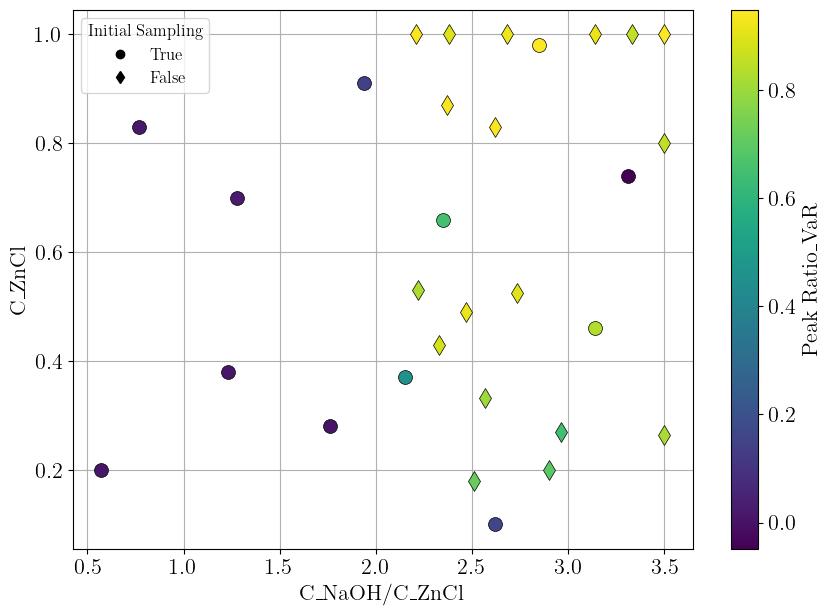

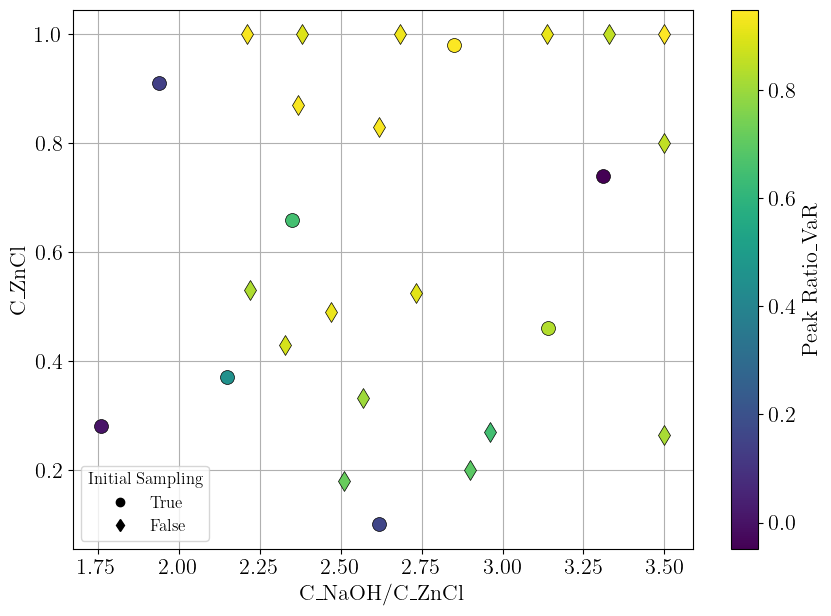

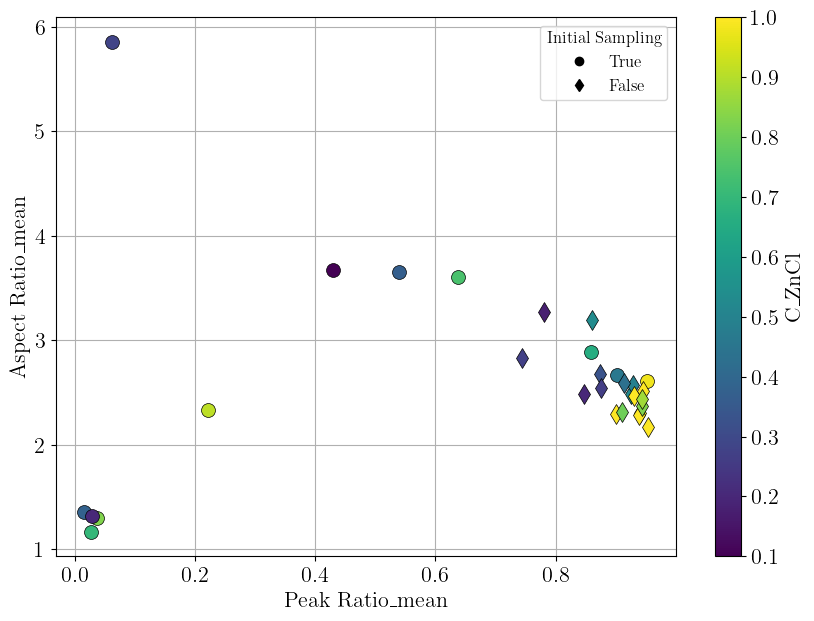

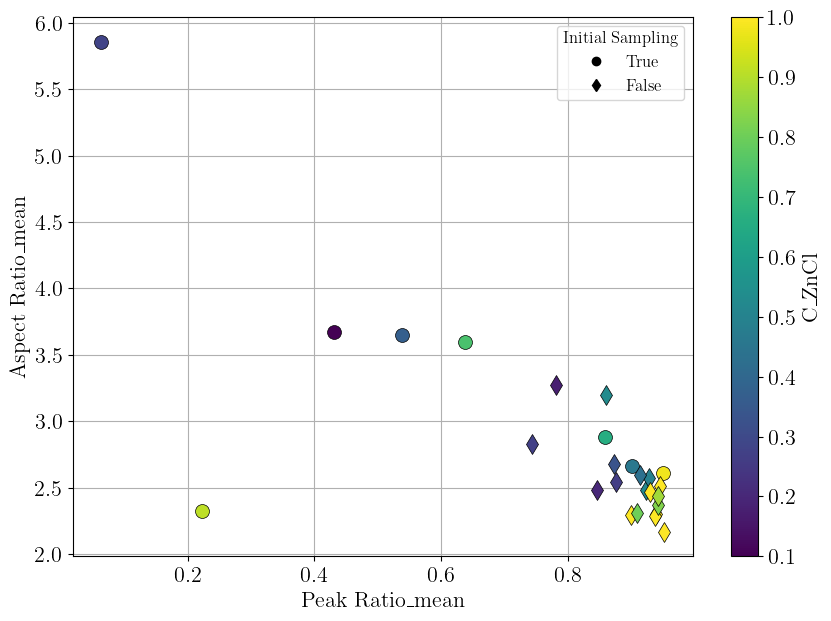

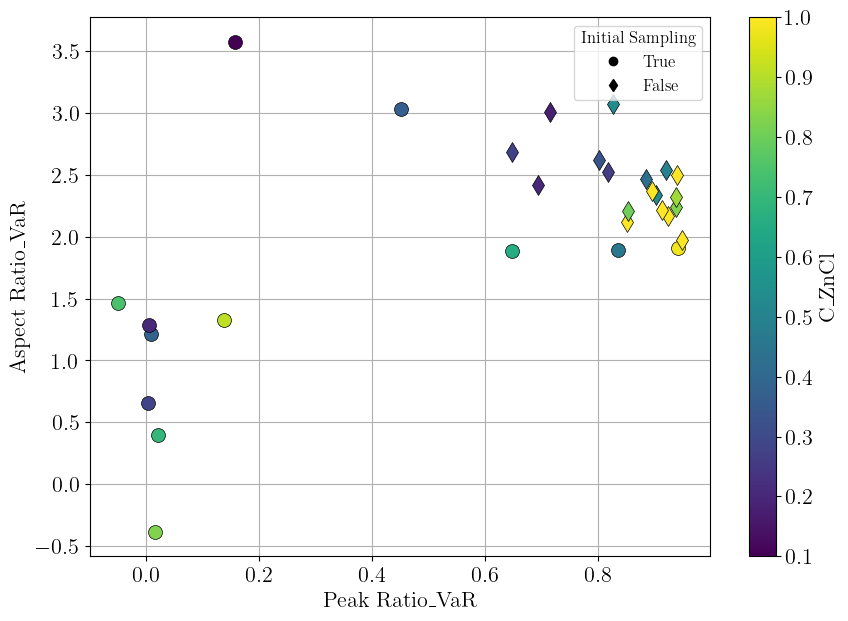

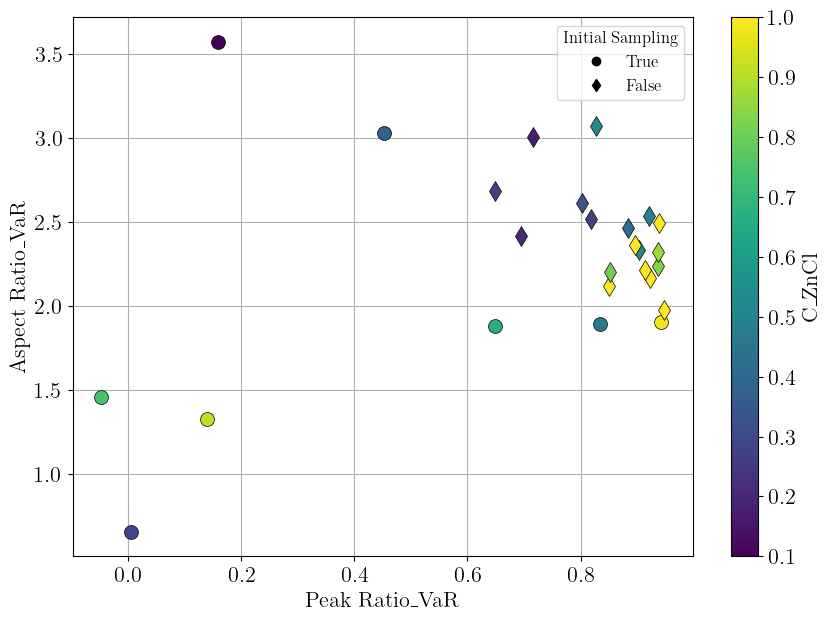

In [ ]:
# %config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)


def is_float_column(column, df):
    return df[column].dtype in [np.float64, np.float32]


def get_color(column, df):
    labels = df[column]
    if is_float_column(column, df):
        # Use a continuous colormap for float-valued columns
        norm = plt.Normalize(labels.min(), labels.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(labels))
    else:
        # Use distinct colors for category or integer-valued columns
        unique_labels = np.unique(labels)
        cmap = plt.cm.tab10
        colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
        colors = np.array([colors_dict[label] for label in labels])

    return colors


def scatter_plot(df, x, y, cc, mc, filter_data=""):

    if filter_data == "filter":
        df = df[df["C_NaOH/C_ZnCl"] > 1.6]

    colors = get_color(cc, df)
    colors_dict = {label: colors[i] for i, label in enumerate(df[cc].unique())}

    markers_all = ["o", "d"]
    markers_dict = {
        label: markers_all[idx % len(markers_all)]
        for idx, label in enumerate(df[mc].unique())
    }
    markers = [markers_dict[label] for label in df[mc]]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    for i in range(df.shape[0]):
        row = df.iloc[i]
        color = colors[i]
        marker = markers[i]
        sc = ax.plot(
            row[x],
            row[y],
            marker=marker,
            color=color,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="black",
            alpha=1.0,
        )

    for m in df[mc].unique():
        ax.plot([], [], marker=markers_dict[m], color="k", label=m, linestyle="None")

    # for c in df[cc].unique():
    #     ax.plot([], [], marker="o", color=colors_dict[c], label=f"{cc}: {c}", linestyle="None")

    ax.legend(fontsize=12, title_fontsize=12, title="Initial Sampling")

    # custom colorbar
    if is_float_column(cc, df):
        # Add a colorbar if 'cc' is a float column
        sm = plt.cm.ScalarMappable(
            cmap=plt.cm.viridis,
            norm=plt.Normalize(vmin=df[cc].min(), vmax=df[cc].max()),
        )
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label=cc)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid(True)

    return fig, ax


columns = df_mean_std.columns

filter_data = "filter"
# filter_data = ""
x = "C_NaOH/C_ZnCl"
y = "C_ZnCl"
# cc = "zero"
# y = "Aspect Ratio_VaR"
# x = "C_NaOH/C_ZnCl"
cc = "Peak Ratio_VaR"
mc = "initial_sampling"


plots_list = [
    ["C_NaOH/C_ZnCl", "C_ZnCl", "Peak Ratio_VaR", "initial_sampling", ""],
    ["C_NaOH/C_ZnCl", "C_ZnCl", "Peak Ratio_VaR", "initial_sampling", "filter"],
    ["Peak Ratio_mean", "Aspect Ratio_mean", "C_ZnCl", "initial_sampling", ""],
    ["Peak Ratio_mean", "Aspect Ratio_mean", "C_ZnCl", "initial_sampling", "filter"],
    ["Peak Ratio_VaR", "Aspect Ratio_VaR", "C_ZnCl", "initial_sampling", ""],
    ["Peak Ratio_VaR", "Aspect Ratio_VaR", "C_ZnCl", "initial_sampling", "filter"],
    ["C_NaOH_C_ZnCl", "C_ZnCl", "Aspect Ratio_VaR", "initial_sampling", ""],
    ["C_NaOH_C_ZnCl", "C_ZnCl", "Aspect Ratio_VaR", "initial_sampling", "filter"],
    [
        "Aspect Ratio_mean",
        "Aspect Ratio_std",
        "C_NaOH_C_ZnCl",
        "initial_sampling",
        "filter",
    ],
    [
        "Peak Ratio_mean",
        "Peak Ratio_std",
        "C_NaOH_C_ZnCl",
        "initial_sampling",
        "filter",
    ],
    [
        "Aspect Ratio_mean",
        "Aspect Ratio_std",
        "C_NaOH",
        "initial_sampling",
        "filter",
    ],
    [
        "Aspect Ratio_mean",
        "Aspect Ratio_std",
        "C_ZnCl",
        "initial_sampling",
        "filter",
    ],
    ["Peak Ratio_mean", "Peak Ratio_std", "C_ZnCl", "initial_sampling", "filter"],
    [
        "Aspect Ratio_mean",
        "Aspect Ratio_std",
        "initial_sampling",
        "initial_sampling",
        "filter",
    ],
    [
        "Peak Ratio_std",
        "Aspect Ratio_std",
        "initial_sampling",
        "initial_sampling",
        "filter",
    ],
    ["Peak Ratio_mean", "Aspect Ratio_mean", "N_ZnO", "initial_sampling", "filter"],
    ["Peak Ratio_std", "Aspect Ratio_std", "N_ZnO", "initial_sampling", "filter"],
    ["Peak Ratio_VaR", "Aspect Ratio_VaR", "N_ZnO", "initial_sampling", "filter"],
    ["C_NaOH_C_ZnCl", "C_ZnCl", "Peak Ratio_VaR", "initial_sampling", "filter"],
    ["Aspect Ratio_mean", "Aspect Ratio_std", "Q_AC", "initial_sampling", "filter"],
    ["Peak Ratio_mean", "Peak Ratio_std", "Q_AC", "initial_sampling", "filter"],
    ["Peak Ratio_mean", "Peak Ratio_std", "Q_AIR", "initial_sampling", "filter"],
]


for config in plots_list:
    
    x,y,cc,mc,filter_data = config 
    
    fig, ax = scatter_plot(df_mean_std, x, y, cc, mc, filter_data)
    save_image(
        fig,
        path,
        f"{exp}/agg/{cc}/{mc}",
        f"{x}+{y}+{cc}+{mc}+{filter_data}".replace("/", "_"),
    )

# fig, ax = scatter_plot(df_mean_std, x, y, cc, mc, filter_data)

# # fig.show()

# path = Path(f"figures/aa/GAS-001/")

# save_pdf(fig, path,f"{exp}/agg/{cc}/{mc}", f"{x}+{y}+{cc}+{mc}+{filter_data}".replace("/", "_"))

####

In [ ]:
path_list = list(Path("./Plots/GAS-004/agg/").glob("*/**/*.pdf"))
path_list = [p.parts[-4:] for p in path_list]

configs = [

]

# [('agg',
#   'Aspect Ratio_VaR',
#   'initial_sampling',
#   'C_NaOH_C_ZnCl+C_ZnCl+Aspect Ratio_VaR+initial_sampling+.pdf'),
#  ('agg',
#   'Aspect Ratio_VaR',
#   'initial_sampling',
#   'C_NaOH_C_ZnCl+C_ZnCl+Aspect Ratio_VaR+initial_sampling+filter.pdf')]

for p in path_list:
    # print(p)
    agg, cc, mc, name = p
    
    name = name.replace(".pdf", "")
    x, y, cc, mc, filter_data = name.split("+")
    # print(x, y, cc, mc, filter_data)
    # print(name)
    configs.append([x, y, cc, mc, filter_data])

configs

[['C_NaOH_C_ZnCl', 'C_ZnCl', 'Aspect Ratio_VaR', 'initial_sampling', ''],
 ['C_NaOH_C_ZnCl', 'C_ZnCl', 'Aspect Ratio_VaR', 'initial_sampling', 'filter'],
 ['Aspect Ratio_mean',
  'Aspect Ratio_std',
  'C_NaOH_C_ZnCl',
  'initial_sampling',
  'filter'],
 ['Peak Ratio_mean',
  'Peak Ratio_std',
  'C_NaOH_C_ZnCl',
  'initial_sampling',
  'filter'],
 ['Aspect Ratio_mean',
  'Aspect Ratio_std',
  'C_NaOH',
  'initial_sampling',
  'filter'],
 ['Aspect Ratio_mean',
  'Aspect Ratio_std',
  'C_ZnCl',
  'initial_sampling',
  'filter'],
 ['Peak Ratio_mean', 'Peak Ratio_std', 'C_ZnCl', 'initial_sampling', 'filter'],
 ['Aspect Ratio_mean',
  'Aspect Ratio_std',
  'initial_sampling',
  'initial_sampling',
  'filter'],
 ['id_idx', 'Acquisition_f1_mean', 'initial_sampling', 'initial_sampling', ''],
 ['id_idx', 'Acquisition_f1_VaR', 'initial_sampling', 'initial_sampling', ''],
 ['id_idx', 'Acquisition_f2_mean', 'initial_sampling', 'initial_sampling', ''],
 ['id_idx', 'Acquisition_f2_VaR', 'initial_samp